In [1]:
import scipy
import time
import math as m
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy import optimize
from scipy import special
from scipy import stats
from scipy import linalg
from multiprocessing import Pool
import matplotlib.path as mpltPath
from numba import njit

from pylab import *
%matplotlib inline

from src import Curve as cv
from src import Utils as ut
from src import BasisFunction as bf
from src import Basis as ba
from src import Billiard as bil
from src import Solvers as solvers
from src import Wavefunctions as wf
from src import RealPlaneWaves as rpw
from src import FourierBessel as fb
from src import Spectrum as spec

rc('text', usetex=True)
rc('font', size=10)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')
rc('axes', labelsize='medium')
rc('legend', fontsize='small')
rc('figure', figsize=(8.6/2.54, 8.6/2.54*0.75))
rc('lines', linewidth=1.5)
rcParams["axes.formatter.limits"] = (-3,4) 


In [2]:
N = 10
fb_basis1 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : -1.0, "nu" : 2, "phi0" :0}])
fb_basis2 = fb.make_FB_basis(par_list=[{"x0" : 1.0, "y0" : -0.25, "nu" : 1, "phi0" :np.pi/2}])
fb_basis3 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])

fb_basis1.set_basis_size([N])
fb_basis2.set_basis_size([N])
fb_basis3.set_basis_size([N])

In [3]:
# line
def line_r(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    x = (x1-x0) * t + x0 
    y = (y1-y0) * t + y0
    return np.array([x, y])

def line_n(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    nx = (y1 - y0)/l*np.ones(len(t))
    ny = (x0 - x1)/l*np.ones(len(t))
    return np.array([nx, ny])

def line_arc(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    return np.array(t * l)

# circle arc
def circle_r(t, R = 1, x0 = 0, y0 = 0, angle = 2*np.pi, shift = 0):
    x = x0 + R * np.cos(t*angle + shift)
    y = y0 + R * np.sin(t*angle + shift)
    return np.array([x, y])

def circle_n(t, angle = 2*np.pi, shift = 0, **kwargs):
    nx = np.cos(t*angle + shift)
    ny = np.sin(t*angle + shift)
    return np.array([nx, ny])

def circle_arc(t, R = 1, angle = 2*np.pi, **kwargs):
    return  np.array(R * angle *t)

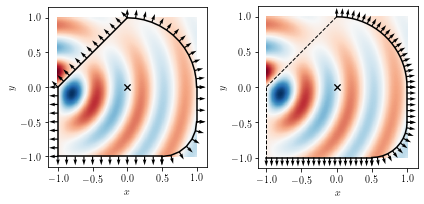

In [4]:
def plot_basis_function(basis,i,j,k):
    basis.basis_functions[i].plot_fun(j,k)

def make_weird_billiard_full(d = 15, dist = None):
    params_1 = {"angle" : np.pi/2}
    arc_1 = cv.curve(circle_r, circle_n, circle_arc, **params_1, distribution_function=dist)
    params_2 = {"x0": 0, "x1": -1, "y0": 1, "y1": 0}
    line_2 = cv.curve(line_r, line_n, line_arc, **params_2, distribution_function=dist, virtual = False)
    params_3 = {"x0": -1, "x1": -1, "y0": 0, "y1": -1}
    line_3 = cv.curve(line_r, line_n, line_arc, **params_3, distribution_function=dist, virtual = False)
    params_4 = {"x0": -1, "x1": 0.5, "y0": -1, "y1": -1}
    line_4 = cv.curve(line_r, line_n, line_arc, **params_4, distribution_function=dist)
    params_5 = {"R" : 0.5, "x0": 0.5, "y0" : -0.5 , "angle" : np.pi/2, "shift" : 3*np.pi/2}
    arc_5 = cv.curve(circle_r, circle_n, circle_arc, **params_5, distribution_function=dist)
    params_6 = {"x0": 1, "x1": 1, "y0": -0.5, "y1": 0}
    line_6 = cv.curve(line_r, line_n, line_arc, **params_6, distribution_function=dist)

    curves = [line_4, arc_5, line_6, arc_1, line_2, line_3 ]
    area = np.pi/4 + 1/2 + 1.5 + np.pi *0.5**2 + 0.5**2
    dens = [d for i in curves]

    return bil.billiard(curves, area, point_densities= dens)
    
def make_weird_billiard(d = 15, dist = None):
    params_1 = {"angle" : np.pi/2}
    arc_1 = cv.curve(circle_r, circle_n, circle_arc, **params_1, distribution_function=dist)
    params_2 = {"x0": 0, "x1": -1, "y0": 1, "y1": 0}
    line_2 = cv.curve(line_r, line_n, line_arc, **params_2, distribution_function=dist, virtual = True)
    params_3 = {"x0": -1, "x1": -1, "y0": 0, "y1": -1}
    line_3 = cv.curve(line_r, line_n, line_arc, **params_3, distribution_function=dist, virtual = True)
    params_4 = {"x0": -1, "x1": 0.5, "y0": -1, "y1": -1}
    line_4 = cv.curve(line_r, line_n, line_arc, **params_4, distribution_function=dist)
    params_5 = {"R" : 0.5, "x0": 0.5, "y0" : -0.5 , "angle" : np.pi/2, "shift" : 3*np.pi/2}
    arc_5 = cv.curve(circle_r, circle_n, circle_arc, **params_5, distribution_function=dist)
    params_6 = {"x0": 1, "x1": 1, "y0": -0.5, "y1": 0}
    line_6 = cv.curve(line_r, line_n, line_arc, **params_6, distribution_function=dist)

    curves = [line_4, arc_5, line_6, arc_1, line_2, line_3 ]
    area = np.pi/4 + 1/2 + 1.5 + np.pi *0.5**2 + 0.5**2
    dens = [d for i in curves]

    return bil.billiard(curves, area, point_densities= dens)

bil0 = make_weird_billiard_full(d = 100, dist = None)
bil1 = make_weird_billiard(d = 100, dist = None)
fig = figure(figsize = (6,8))
subplot(1,2,1)
plot_basis_function(fb_basis3,0,0,10)
bil0.plot_boundary()
subplot(1,2,2)
plot_basis_function(fb_basis3,0,0,10)
bil1.plot_boundary()



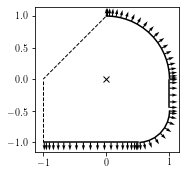

In [5]:
def chebyshev_nodes(t_vals):
    N = len(t_vals)
    pts = np.arange(1,N,1)
    t = np.cos((2*pts-1)/(2*N)*np.pi)[::-1]
    return (t+1)/2
bil2 = make_weird_billiard(d = 20, dist = chebyshev_nodes)
bil2.plot_boundary(M = 10)

In [6]:
#fb_basis3.set_basis_size([100])
fb_basis_1 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])
fb_basis_1.set_basis_size([10])
fb_basis_2 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])
fb_basis_2.set_basis_size([100])

problem0 = spec.spectrum(bil0, fb_basis_1)
problem1 = spec.spectrum(bil0, fb_basis_2)
wavefunctions0 = wf.wavefunctions(bil0, fb_basis_1)
wavefunctions1 = wf.wavefunctions(bil0, fb_basis_2)

rpw_basis_1 = rpw.make_RPW_basis()
rpw_basis_1.set_basis_size([5,5])

rpw_basis_2 = rpw.make_RPW_basis()
rpw_basis_2.set_basis_size([50,50])

problem2 = spec.spectrum(bil0, rpw_basis_1)
problem3 = spec.spectrum(bil0, rpw_basis_2)
wavefunctions2 = wf.wavefunctions(bil0, rpw_basis_1)
wavefunctions3 = wf.wavefunctions(bil0, rpw_basis_2)


1.4342474937438965 seconds
10.34349799156189 seconds
0.1063072681427002 seconds
0.8270969390869141 seconds


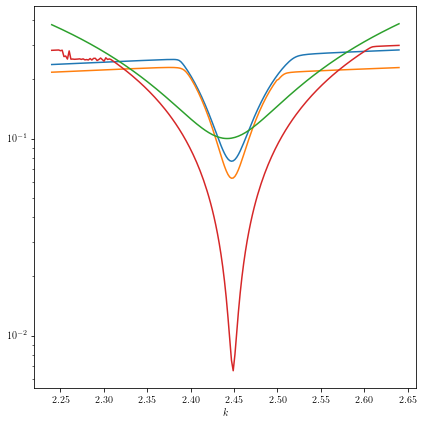

In [7]:
k0 = 2.44
dk = 0.2

fig = figure(figsize = (6,6))
#subplot(1,2,1)
start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk)
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk)
print("%s seconds" % (time.time() - start_time))

tight_layout()



0.9543778896331787 seconds
7.246790885925293 seconds
0.4696619510650635 seconds
2.2581136226654053 seconds


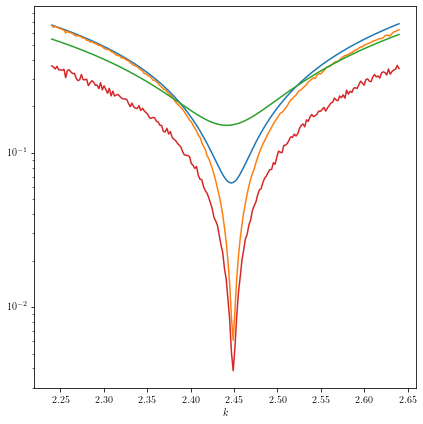

In [8]:
k0 = 2.44
dk = 0.2

fig = figure(figsize = (6,6))
#subplot(1,2,1)
start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))

tight_layout()

7.343434572219849 seconds
2.230433702468872 seconds


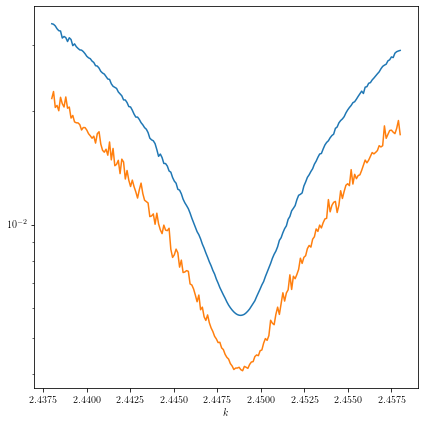

In [9]:
k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))
#subplot(1,2,1)

start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver="PSM")
print("%s seconds" % (time.time() - start_time))

tight_layout()

85.8742892742157 seconds
4.315293550491333 seconds


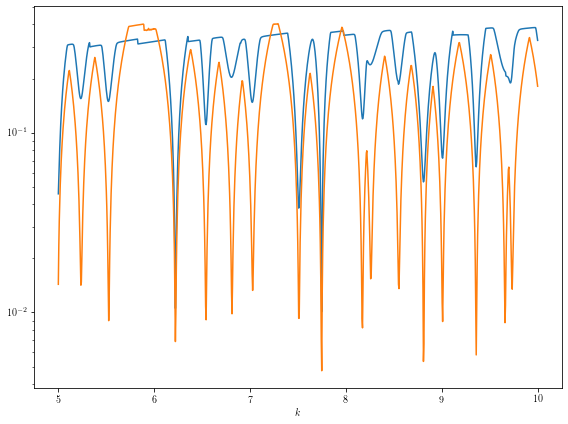

In [10]:
k1 = 5
k2 = 10

fig = figure(figsize = (8,6))
#subplot(1,2,1)
start_time = time.time()
problem1.plot_tension(k1, k2, grid = 1000)
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem3.plot_tension(k1, k2, grid = 1000)
print("%s seconds" % (time.time() - start_time))

tight_layout()

55.37568020820618 seconds
12.040358781814575 seconds


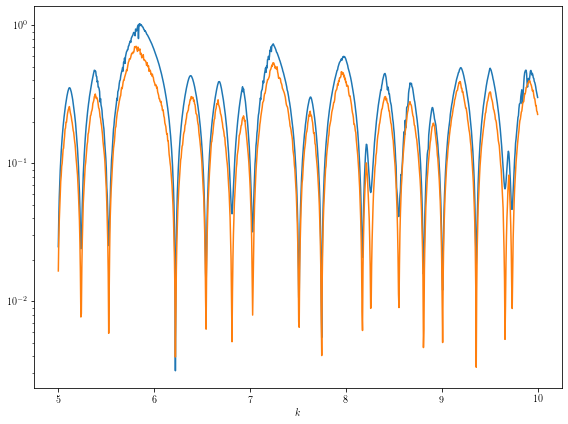

In [11]:
k1 = 5
k2 = 10

fig = figure(figsize = (8,6))
#subplot(1,2,1)
start_time = time.time()
problem1.plot_tension(k1, k2, grid = 1000, solver="PSM")
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem3.plot_tension(k1, k2, grid = 1000, solver="PSM")
print("%s seconds" % (time.time() - start_time))

tight_layout()

In [7]:
start_time = time.time()
spect, ten = problem3.compute_spectrum(5, 0.5, 20, overlap = 0.3, return_tensions = True)
print("%s seconds" % (time.time() - start_time))

TypeError: cannot unpack non-iterable basis object

In [ ]:
spect, ten = problem1.compute_spectrum(5, 0.1, 20, overlap = 0.3, return_tensions = True)

In [ ]:
fig = figure(figsize = (8,8))
subplot(2,2,1)
k = problem0.compute_k(k0, dk, solver = "DM")
wavefunctions0.plot_probability(k, grid = 400, cmap='binary', plot_full = True)
subplot(2,2,2)
k = problem1.compute_k(k0, dk, solver = "DM")
wavefunctions1.plot_probability(k, grid = 400, cmap='binary', plot_full = True)
subplot(2,2,3)
k = problem2.compute_k(k0, dk, solver = "DM")
wavefunctions2.plot_probability(k, grid = 400, cmap='binary', plot_full = True)
subplot(2,2,4)
k = problem3.compute_k(k0, dk, solver = "DM")
wavefunctions3.plot_probability(k, grid = 400, cmap='binary', plot_full = True)

tight_layout()

In [ ]:
fig = figure(figsize = (8,8))
subplot(2,2,1)
k = problem0.compute_k(k0, dk, solver = "DM")
wavefunctions0.plot_boundary_function(k, delta = 1, virtual_curves = True, plot_curve_bounds = True)
subplot(2,2,2)
k = problem1.compute_k(k0, dk, solver = "DM")
wavefunctions1.plot_boundary_function(k, delta = 1, virtual_curves = False, plot_curve_bounds = True)
subplot(2,2,3)
k = problem2.compute_k(k0, dk, solver = "DM")
wavefunctions2.plot_boundary_function(k, delta = 1, virtual_curves = False, plot_curve_bounds = True)
subplot(2,2,4)
k = problem3.compute_k(k0, dk, solver = "DM")
wavefunctions3.plot_boundary_function(k, delta = 1, virtual_curves = False, plot_curve_bounds = True)

tight_layout()

In [ ]:
fig = figure(figsize = (8,8))
subplot(2,2,1)
k = problem0.compute_k(k0, dk, solver = "DM")
wavefunctions0.plot_Husimi_function(k, delta = 1, virtual_curves = False, cmap='magma')
subplot(2,2,2)
k = problem1.compute_k(k0, dk, solver = "DM")
wavefunctions1.plot_Husimi_function(k, delta = 1, virtual_curves = True, cmap='magma')
subplot(2,2,3)
k = problem2.compute_k(k0, dk, solver = "DM")
wavefunctions2.plot_Husimi_function(k, delta = 1, virtual_curves = False, cmap='magma')
subplot(2,2,4)
k = problem3.compute_k(k0, dk, solver = "DM")
wavefunctions3.plot_Husimi_function(k, delta = 1, virtual_curves = False, cmap='magma')

tight_layout()

In [ ]:
problem0.compute_k(k0, dk, solver = "DM")

In [ ]:
problem1.compute_k(k0, dk, solver = "DM")

In [14]:
problem1.compute_k(k0, dk, solver = "SM")

NameError: name 'eps' is not defined

In [ ]:
solvers.decomposition_method(10, bil0, fb_basis_2, eps = 0.5e-15, return_vector = False, show_matrix=True)

In [ ]:
solvers.decomposition_method(10, bil1, rpw_basis_2, eps = 0.5e-15, return_vector = False, show_matrix=True)

In [ ]:
solvers.particular_solutions_method(10, bil0, fb_basis_2, eps = False, return_vector = False, show_matrix=True)

In [ ]:
solvers.particular_solutions_method(10, bil1, rpw_basis_2, eps = False, return_vector = False, show_matrix=True)

In [ ]:
solvers.scaling_method(10,1 , bil1, fb_basis_2, eps = 0.5e-15, return_vector = False, show_matrix=True)

In [ ]:
solvers.scaling_method(10,1 , bil1, rpw_basis_2, eps = 0.5e-15, return_vector = False, show_matrix=True)